**READ.ME**

This file helps you explore the functions of Brightway 2.5 in an intuitive way. So far, we have linked a background database with a simple foreground model in the previous sections of this repository.

It is not a tutorial to go through, but a collection of usable code which you can adapt for your own projects. The goal is to make Brightway 2.5 easy to use for your own projects. Any contribution to this overview is welcome.


## 🌍 Brightway 2.5 - Quick Exploration Guide

Before analyzing a Brightway model, ensure all required packages, databases, and projects are installed. These have already been set up in other scripts in this repository, so we can call them directly from the project folder stored in Brightway without re-importing or re-matching background databases.

### ⚙️ Step 1: Load Your Project

After ensuring all necessary packages are installed, you call the same project where you have installed and imported your databases. This happens through `bd.projects.set_current('LCA_Toolbox')`



In [ ]:
# basic packages from brightway
import bw2analyzer as ba
import bw2calc as bc
import bw2data as bd
import bw2io as bi
from bw2io.importers import SingleOutputEcospold2Importer
import bw2analyzer as bwa
from bw2data import methods

# other relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

In [ ]:
# call the project we want to work in, in this case brightway25 where we have set up the databases
bd.projects.set_current('LCA_Toolbox')

In [ ]:
sorted(bd.projects)

### ⚙️ Step 2: Database overview

This section provides an overview of the background and foreground databases stored in the Brightway project.

In [ ]:
bd.databases

In [ ]:
del bd.databases["ecoinvent310clca"]

In [ ]:
bd.projects.current

In [ ]:
ei_bio = bd.Database('ecoinvent-3.10-biosphere')
db_template = bd.Database('bw25_db')
el_bio3 = bd.Database('biosphere3')
ei_clca = bd.Database('ecoinvent-3.11-consequential')

#### 🔍 Step 3: Searching the Database

Use the following `database.search('')` function to search for entries in your database

In [ ]:
# search for activities in the database
db_template.search('ceramics')

In [ ]:
ei_clca.search('steel turning')

In [ ]:
# select a random activity from the database
ei_clca.random()

#### 🧾 Step 4: Select a Process & Check Inventory

`define_name = database.get(name='', location='', unit='')` assigns the object "define_name" to the entry in the database that matches the search criteria.
    
You can directly export the inventory of the defined process to an Excel overview through `bi.export.excel.write_lci_excel(database.name, objs=[define_name], dirpath=Path.cwd())`.

    

In [ ]:
# define a process and store in a object in the project
ceramics_bw = db_template.get(name = 'porcelain ceramics production', location = "RER", unit = 'kilogram')
ceramics_ei = ei_clca.get(name = 'sanitary ceramics production', location = "CH", unit = 'kilogram')

blasting = ei_clca.get(name = 'abrasive blasting, alumina, carbon steel substrate', location = "GLO", unit = 'square meter')
turning = ei_clca.get(name = 'chromium steel turning, primarily roughing, conventional', location = "RER", unit = 'kilogram')

ammonia = ei_clca.get(name = 'ammonia production, steam reforming, liquid', location = "RER w/o RU", unit = 'kilogram')
formic_acid = ei_clca.get(name = 'formic acid production, methyl formate route', location = "RER", unit = 'kilogram')

In [ ]:
# export the LCI to Microsoft Excel in an overview format
bi.export.excel.write_lci_excel(ei_clca.name, objs=[turning], dirpath=Path.cwd())

In [ ]:
# print the outputs of the process
list(ceramics_ei.production())

In [ ]:
# print the consumers of a product
list(ceramics_ei.consumers())


In [ ]:
# (1) this is a way to print all exchanges of a process, there are multiple ways to extract this information
list(ceramics_ei.edges())


In [ ]:
# (2) this is an other way to print all exchanges of a process
exchanges = sorted(ceramics_ei.exchanges(), key=lambda exc: exc['amount'], reverse=True)
for exc in exchanges:
    print(exc)

In [ ]:
# (3) Alternative way to display all exchanges with the technosphere
list(ceramics_ei.technosphere())


In [ ]:
# how to check the activity type of a process
check_activity_type = print(ceramics_ei["activity type"])

### 🌿 Step 4: Impact Assessment Methods

To calculate the Life Cycle Impacts the back- and foreground need to be linked to an assessment method. There is a large number of available methods that are pre-installed together with the ecoinvent biosphere flows in the 01_bw25_ecoinvent_importer script.

In [ ]:
# here we will analyse the set of methods that are available as part of the background
list(bd.methods)[:5]

In [ ]:
# printing all methods that contain a specific keyword, e.g. "climate change"
climate_methods = [m for m in bd.methods if any("climate change" in str(part).lower() for part in m)]
for method in climate_methods:
    print(method)

In [ ]:
# selecting the impact assessment methods that we want to use in our analysis
lcia_gwp100 = ('EF v3.1', 'climate change', 'global warming potential (GWP100)')
lcia_water = ('EF v3.1','water use','user deprivation potential (deprivation-weighted water consumption)')
lcia_land = ('EF v3.1', 'land use', 'soil quality index')

### 📈 5. LCIA

This section shows how LCA results can be calculated quickly and be displayed as final score, process- and elementary flow based.

In [ ]:
# Quick LCIA calculation
ammonia_lca = ammonia.lca(lcia_gwp100)
ammonia_lca.score


In [ ]:
formic_acid_lca = formic_acid.lca(lcia_gwp100)
formic_acid_lca.score

In [ ]:
# Elementary flows contribution analysis by process
ammonia_lca.to_dataframe().pivot_table(index=['col_name', 'row_name'], values='amount', aggfunc='sum').sort_values(by='amount', ascending=False)

In [ ]:
# Elementary flows contribution analysis as summary table
ammonia_lca.to_dataframe().pivot_table(index='row_name',values='amount',aggfunc='sum')

### 📊 6. Contribution analysis

There are different ways to analyse the contribution analysis in Brightway 2.5. Two ways are displayed below. The max_level and cutoff can be adjusted based on the level of detail you want from the analysis.

In [ ]:
# One option to do a contribution analysis is to use the recursive calculation method
bwa.print_recursive_calculation(ammonia,
lcia_method=lcia_gwp100,max_level=3,cutoff=0.05)

In [ ]:
# Another option is to use the recursive calculation to an object, which returns a DataFrame
ammonia_lca_ca = bwa.utils.recursive_calculation_to_object(ammonia,
                                          lcia_method=lcia_gwp100,
                                          max_level=1,
                                          cutoff=0.02,
                                          as_dataframe=True,
                                          )
ammonia_lca_ca

### 🎨 7. Plot Contribution analysis graphs

In [ ]:
# Filter out the parent processes that are not relevant for the contribution analysis
ammonia_lca_ca = ammonia_lca_ca.dropna(subset='parent') 

In [ ]:
# First, we plot the contribution analysis for the brigthway ceramics production process
f, ax = plt.subplots(figsize=(6, 3))
sns.barplot(y='name', x='score', data=ammonia_lca_ca, ax=ax)
ax.set(
    title='Contribution analysis of the product under study',
    xlabel='CO2 eq. emissions (kg)',
    ylabel='')
plt.tight_layout()
plt.show()


### ⚖️ 8. Comparison

Only your creativity limits you in what you can do with the results from the impact assessment and contribution analysis. The data can also be stored in a combined dataframe (=combined_df) to then be shown in the same graph conveniently.

In [ ]:
# This is an example for combining two results in one table
combined_df = pd.concat([contribution_analysis_A.set_index('name').score,contribution_analysis_B.set_index('name').score],
                        keys=['ceramics_bw','ceramics_ei'],
                        names=['activity','contributor'])
combined_df

In [ ]:
ax = combined_df.unstack().plot.barh(
    stacked=True,
    title='Main contributors to global warming',
    xlabel='kg CO2eq',
    figsize=(10,6)
)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # moves legend outside
plt.tight_layout()
plt.show()

### 🖥️ 9. Use brightway interfaces to change background data on the fly

Brightway interfaces provide structured access to life cycle data, methods, and calculations within the Brightway framework. They let users import, modify, and connect background and foreground data without manually handling complex matrices. Through these interfaces, you can build scenarios, run parametric studies, and link external databases or tools to Brightway in a reproducible way.

In [9]:
date_range = pd.date_range(start='2023-01-01',end='2023-02-28')
data = pd.Series(np.random.normal(loc=8,scale=1,size=len(date_range)),
                 index=date_range).to_frame('electricity')
#data['weekday'] = data.index.weekday
data['dayname'] = data.index.day_name()
data['month_name'] = data.index.month_name()

data.loc[data.dayname.isin(['Monday','Tuesday']),'product'] = 'A'
data.loc[data.dayname.isin(['Wednesday','Thursday','Friday']),'product'] = 'B'

# electricity consumption
data.loc[data.dayname.isin(['Monday','Tuesday']),'electricity'] = \
data.loc[data.dayname.isin(['Monday','Tuesday']),'electricity'] * 0.7

# not working on weekends
data.loc[data.dayname.isin(['Saturday','Sunday']),'electricity'] = 0 

# improvements in production of product A
data.loc[(data.month_name=='February')&(data['product']=='A'),'electricity'] = (
    data.loc[(data.month_name=='February')&(data['product']=='A'),'electricity'] * 0.5)

<Axes: >

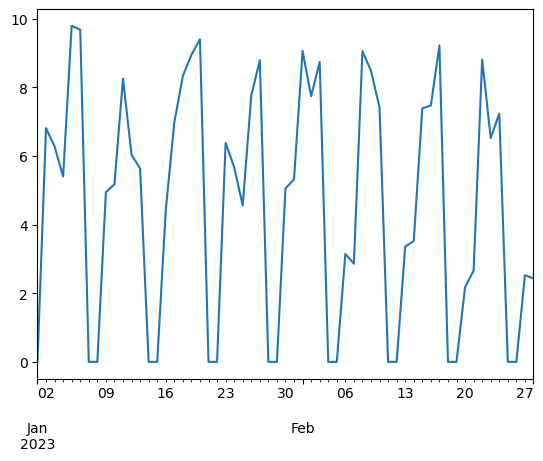

In [10]:
data.electricity.plot()
